This is a more advanced notebook which tests different tilt and azimuth configurations for the town of Oldenburg. 

Here, we try to find the optimal tilt and azimuth configuration for Oldenburg. In contrast to using more sophisticated optimization techniques (as in the review paper illustrated), we simply use a brute-forcing approach --> This means we design multiple plausible values and testing all the different combinations (time consuming).

This is only for educational purpose. A more realistic simulation should take more weather-years into account.

In [1]:
import atlite
import xarray as xr
import numpy as np

In [2]:
from atlite.pv.solar_position import SolarPosition
from atlite.pv.irradiation import TiltedIrradiation
from atlite.pv.solar_panel_model import SolarPanelModel
from atlite.pv.orientation import get_orientation, SurfaceOrientation
from atlite.convert import pv, convert_pv, get_orientation,get_solarpanelconfig

In [3]:
ds = xr.open_dataset("assets/data_2017_germany.nc")

In [4]:
layout = xr.open_dataarray("assets/layouts.nc") # [years, y, x]
layout = layout.sel({"time":2017})
layout = layout.sel({"x": [8.25], "y": [53]})

In [5]:
ds_oldenburg = ds.sel({"x": [8.25], "y": [53]})

In [6]:
time_shift = 0 # relevant if sarah-2 data is used
solar_position = SolarPosition(ds_oldenburg, time_shift)
solar_position.load() # this takes some time

<xarray.Dataset>
Dimensions:   (time: 8760, y: 1, x: 1)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
  * y         (y) float32 53.0
    lat       (y) float32 53.0
  * x         (x) float32 8.25
    lon       (x) float32 8.25
Data variables:
    altitude  (time, y, x) float64 -1.038 -0.9689 -0.8514 ... -0.9682 -1.038
    azimuth   (time, y, x) float64 0.2353 0.6676 1.012 ... 5.266 5.61 6.042

# One simulation

In [7]:
def calc_simu(tilt, azimuth):
    orientation={'slope': tilt, 'azimuth': azimuth}
    panel = "CSi"
    panel = get_solarpanelconfig(panel)
    orientation = get_orientation(orientation)

    surface_orientation = SurfaceOrientation(ds_oldenburg, solar_position, orientation)
    irradiation = TiltedIrradiation(
        ds_oldenburg,
        solar_position,
        surface_orientation,
        trigon_model="simple",
        clearsky_model="simple",
    )
    solar_panel = SolarPanelModel(ds_oldenburg, irradiation, panel)

    return solar_panel

In [8]:
%%time 
ds_0_30 = calc_simu(tilt=30, azimuth=0)

CPU times: user 42.7 ms, sys: 0 ns, total: 42.7 ms
Wall time: 42 ms


We keep the x,y coordinates --> Xarray is able to map this and identify if it is only one value entry or multiple (this is called "broadcasting")

In [9]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'simulation for Oldenburg')

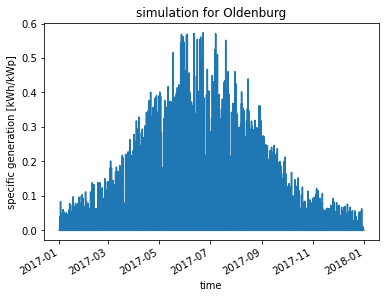

In [10]:
ds_0_30.plot()
plt.title("simulation for Oldenburg")

In [11]:
y = (ds_0_30 * layout)
ysum = y.sum(["x", "y"])

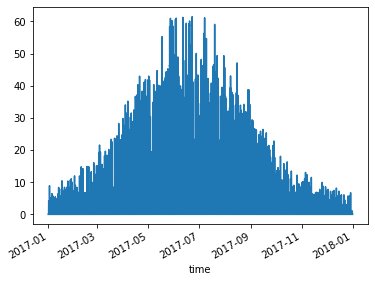

In [12]:
ysum.plot()

# Prepare simulations

In [13]:
import itertools

In [14]:
# Brute-force approach

In [15]:
grid_azs = np.arange(90,270,5) # 0-180°
grid_tilts = np.arange(0,90,3) # 0-90°
total_combinations = len(grid_azs) * len(grid_tilts)
tilt_azimuth_combinations = list(itertools.product(grid_azs, grid_tilts))
assert total_combinations == len(tilt_azimuth_combinations)

In [16]:
len(tilt_azimuth_combinations)

1080

In [17]:
def calc_simu(tilt, azimuth):
    orientation={'slope': tilt, 'azimuth': azimuth}
    panel = "CSi"
    panel = get_solarpanelconfig(panel)
    orientation = get_orientation(orientation)

    surface_orientation = SurfaceOrientation(ds_oldenburg, solar_position, orientation)
    irradiation = TiltedIrradiation(
        ds_oldenburg,
        solar_position,
        surface_orientation,
        trigon_model="simple",
        clearsky_model="simple",
    )
    solar_panel = SolarPanelModel(ds_oldenburg, irradiation, panel)
    y = (solar_panel * layout)
    ysum = y.sum(["x", "y"])
    return {(tilt,azimuth):ysum}

In [18]:
import multiprocessing
from collections import ChainMap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
grid_azs = np.arange(30,330,3) 
grid_tilts = np.arange(0,80,2) # 0-90°
grid = np.meshgrid(grid_tilts, grid_azs)
total_combinations = len(grid_azs) * len(grid_tilts)
tilt_azimuth_combinations = list(itertools.product(grid_tilts, grid_azs))
assert total_combinations == len(tilt_azimuth_combinations)
total_combinations

4000

Text(0.5, 1.0, 'grid of tested combinations')

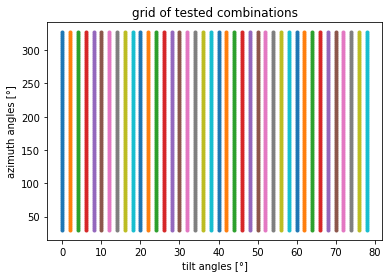

In [20]:
plt.plot(grid[0], grid[1], ".");
plt.xlabel("tilt angles [°]")
plt.ylabel("azimuth angles [°]")
plt.title("grid of tested combinations")

# Make the simulation 
##### adapt the number of processes (here 12) to the cores available on your computer

In [21]:
%%time

with multiprocessing.Pool(processes=12) as pool:
    results = pool.starmap(calc_simu, tilt_azimuth_combinations)
#print(results)

CPU times: user 387 ms, sys: 457 ms, total: 844 ms
Wall time: 12.5 s


# Interpretation

In [22]:
data = dict(ChainMap(*results))

In [23]:
df = pd.DataFrame(data).T
df.index.names = ["tilt","azimuth"]
df_sum = df.sum(axis=1)
df_sum = df_sum.to_frame("energy_sum")
df_sum = df_sum.reset_index()
df_sum

,tilt,azimuth,energy_sum
0,78,327,43386.180775
1,78,324,44720.746699
2,78,321,46100.108788
3,78,318,47520.433413
4,78,315,48992.006256
...,...,...,...
3995,0,42,90388.814170
3996,0,39,90388.814170
3997,0,36,90388.814170
3998,0,33,90388.814170


In [24]:
df_piv=df_sum.pivot('azimuth', 'tilt', 'energy_sum')


In [25]:
grid_azs = np.arange(60,300,3) 
grid_tilts = np.arange(0,80,2) 
total_combinations = len(grid_azs) * len(grid_tilts)
tilt_azimuth_combinations = list(itertools.product(grid_tilts, grid_azs))
assert total_combinations == len(tilt_azimuth_combinations)
total_combinations

3200

In [26]:
%%time

with multiprocessing.Pool(processes=12) as pool:
    results = pool.starmap(calc_simu, tilt_azimuth_combinations)
#print(results)

CPU times: user 534 ms, sys: 336 ms, total: 871 ms
Wall time: 10.7 s


In [27]:
from collections import ChainMap
import pandas as pd

data = dict(ChainMap(*results))
df = pd.DataFrame(data).T

In [28]:
df.index.names = ["azimuth", "tilt"]
df_sum = df.sum(axis=1)
df_sum = df_sum.to_frame("energy_sum")
df_sum = df_sum.reset_index()
df_piv=df_sum.pivot('azimuth', 'tilt', 'energy_sum')

In [29]:
tilt_opt_fy, az_opt_fy = df_sum.set_index(["tilt", "azimuth",]).idxmax().values[0]
tilt_opt_fy, az_opt_fy

(201, 36)

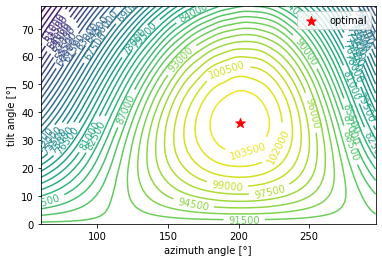

In [30]:
X=df_piv.columns.values
Y=df_piv.index.values
Z=df_piv.values
x,y=np.meshgrid(X, Y)
CS = plt.contour(x, y, Z, levels=50) #the NAN will be plotted as white spaces
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(tilt_opt_fy, az_opt_fy,  marker='*', s=100, c="red", zorder=1) #the NAN will be plotted as white spaces
plt.xlabel("azimuth angle [°]")
plt.ylabel("tilt angle [°]")
plt.legend(["optimal"])


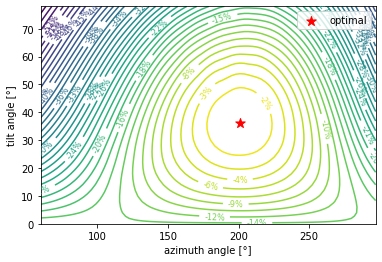

In [31]:
X=df_piv.columns.values
Y=df_piv.index.values
Z=df_piv.values
Z = -(1-Z/Z.max())*100
x,y=np.meshgrid(X, Y)
CS = plt.contour(x, y, Z, levels=50) #the NAN will be plotted as white spaces
plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f%%')
plt.scatter(tilt_opt_fy, az_opt_fy,  marker='*', s=100, c="red", zorder=1) #the NAN will be plotted as white spaces
plt.xlabel("azimuth angle [°]")
plt.ylabel("tilt angle [°]")
plt.legend(["optimal"])


In [32]:
hours=24*45
idx_winter_ext = list(range(0,hours)) + list(range(8760-hours,8760))
df_sum = df[idx_winter_ext].sum(axis=1)
df_sum = df_sum.to_frame("energy_sum")
df_sum = df_sum.reset_index()
df_piv = df_sum.pivot('azimuth', 'tilt', 'energy_sum')

In [33]:
tilt_opt_winter, az_opt_winter = df_sum.set_index(["tilt", "azimuth",]).idxmax().values[0]
tilt_opt_winter, az_opt_winter

(192, 68)

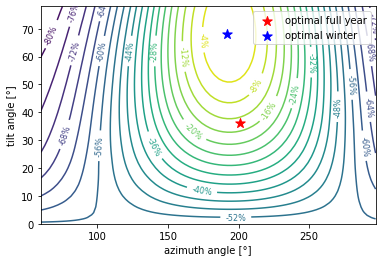

In [34]:
X=df_piv.columns.values
Y=df_piv.index.values
Z=df_piv.values
Z = -(1-Z/Z.max())*100

x,y=np.meshgrid(X, Y)
CS = plt.contour(x, y, Z, levels=25) #the NAN will be plotted as white spaces
plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f%%')
plt.scatter(tilt_opt_fy, az_opt_fy,  marker='*', s=100, c="red", zorder=1) #the NAN will be plotted as white spaces
plt.scatter(tilt_opt_winter, az_opt_winter,  marker='*', s=100, c="blue", zorder=1) #the NAN will be plotted as white spaces
plt.xlabel("azimuth angle [°]")
plt.ylabel("tilt angle [°]")
plt.legend(["optimal full year", "optimal winter"])


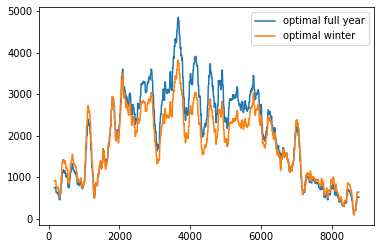

In [35]:
df.loc[az_opt_fy, tilt_opt_fy].rolling(24*7).sum().plot()
df.loc[az_opt_winter, tilt_opt_winter].rolling(24*7).sum().plot()
plt.legend(["optimal full year", "optimal winter"])


In [36]:
df_sum_fy = df.loc[(az_opt_fy, tilt_opt_fy), idx_winter_ext].sum()
df_sum_winter = df.loc[(az_opt_winter, tilt_opt_winter), idx_winter_ext].sum()
print(f"only winter has {df_sum_winter} compared to {df_sum_fy} which makes an improvement fo {(df_sum_winter-df_sum_fy)/df_sum_fy*100 :.2f}% or {df_sum_winter-df_sum_fy :.2f}kWh")

only winter has 11834.286905804707 compared to 10210.434147334876 which makes an improvement fo 15.90% or 1623.85kWh


In [37]:
df_sum_fy = df.loc[(az_opt_fy, tilt_opt_fy), ].sum()
df_sum_winter = df.loc[(az_opt_winter, tilt_opt_winter), ].sum()
print(f"Over the year only winter has {df_sum_winter} compared to {df_sum_fy} which makes an improvement fo {(df_sum_winter-df_sum_fy)/df_sum_fy*100 :.2f}% or {df_sum_winter-df_sum_fy :.2f}kWh")

Over the year only winter has 93747.38784523593 compared to 104806.54299826444 which makes an improvement fo -10.55% or -11059.16kWh
